<div style="color:#8b1538; font-size:35px;">Benchmark of Dadi</div>

In [2]:
import ast
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sei.files.files as f
import sei.graphics.plot as plot
import sei.simulation.msprime as ms
import sei.sei as sei

<br>

<div style="color: #8b1538; font-size: 28px">1. Weighted square distance</div><br>

The weighted square distance $\large{d^2}$ is:

1. Between the observed SFS $\large{\eta^{obs}}$ and the predicted SFS by model M1 $\large{\eta^{model}}$ [1]

\begin{equation}
\Large{ d^2(\eta^{model}, \eta^{obs}) = \sum_{i=1}^{n}{\frac{(\eta^{model}_i - \eta^{obs}_i)^2}{\eta^{model}_i }} }
\end{equation}

2. Between the inferred SFS of two models ($\large{\eta^{m2}}$ & $\large{\eta^{m1}}$)

\begin{equation}
\Large{ d^2(\eta^{m0}, \eta^{m1}) = \sum_{i=1}^{n}{\frac{(\eta^{m0}_i - \eta^{m1}_i)^2}{ (\eta^{m0}_i + \eta^{m1}_i) / 2 }} }
\end{equation}

Start the sum from 2 to ignore singletion (i=2).

<br>

<div style="color: #8b1538; font-size: 15px;">[1] Each SFS must be normalized for comparison</div>

> Compute weighted square distance between theoritical SFS of any constant population & observed SFS (msprime)

Permet  de déterminer pour quel paramètre (Tau, Kappa) les SFS observés sont différenciés du SFS théorique de n'importe quelle population constante, i.e. déterminer quand les SFS permettent de repérer un changement de taille de population.

In [2]:
def compute_theoritical_sfs(length):
    """
    compute the theoritical sfs of any constant population.
    """
    theoritical_sfs = [0] * (length)
    for i in range(length):
        theoritical_sfs[i] = 1 / (i+1)
    return theoritical_sfs


def normalization(sfs):
    """
    Normalization to (0;1)
    """
    return [ele / sum(sfs) for ele in sfs]


def compute_weighted_square_distance(data):
    theoritical_sfs = normalization(compute_theoritical_sfs(19))
    d2 = {}
    
    for i, row in data.iterrows():
        d2[i] = []
        for sfs in row['SFS observed']:
            for eta_obs, eta_theo in zip(normalization(sfs), theoritical_sfs):
                d2[i].append(np.power(eta_obs - eta_theo, 2) / eta_theo)
           
        d2[i] = np.mean(d2[i])
    
    return d2

<br>

<div style="color: #8b1538; font-size: 32px">2. Log-likelihood ratio test</div><br>

Likelihood ratio test lrt assess the godness fit of two model. It's allow you to test wheter adding parameters to models significantly increase the likelihood the model.

1. Likelihood ratio test

\begin{equation}
\large{ lrt = -2*\frac{L0}{L1} }
\end{equation}

with L0 the likelihood of m0 and L1 the likelihood of m1 <br>

2. Log-likelihood ratio test

\begin{equation}
\large{ log(lrt) = 2 * (log_{10}L1 - log_{10}L0) }
\end{equation}

with $log_{10}L0$ the log-likelihood of m0 and $log_{10}L1$ the log-likelihood of m1

<br>

**Models**

* M0 a n0-parameter model - the model with less parameters

* M1 a n1-parameter model - the model with more parameters

with n0 < n1 (number of parameters)

<br>

**Hypothesis**

* H0 the null hypothesis - adding the parameter(s) does not significantly increase the likelihood of the model

* H1 the alternative hypothesis - adding the parameter(s) significantly increase the likelihood of the model

<br>

**Decision rule**

* If p-value >= $\alpha$ then the test is insignificant and do not reject of H0

* If p-value < $\alpha$ then the test is significant and reject of H0

with $\alpha = 0.05$

<br>

**Degrees of freedom**

The difference in the number of parameters between M0 and M1, i.e. n1 - n0

<br>

<div style="color: #8b1538; font-size: 28px;">Vérification des paramètres estimés par Dadi</div>

Check infered parameters by Dadi.

In [3]:
def extract_parameters(data, key):
    """
    Extract from the pandas DataFrame data, the observed parameters key for each simulation and 
    the estimated one of each inferrence (the mean of inferred key for the 100 inferrence).
    
    Return the parameters estimated and observed in log10 scale.

    Return
    ------
    parameters: dict
      - Observed: the observed parameters key of each simulation
      - Estimated: the estimated parameters key of each inferrence (the mean)
    """
    parameters = {'Observed': [], 'Estimated': []}
    
    for _, row in data.iterrows():
        parameters['Observed'].append(row['Parameters'][key])
        parameters['Estimated'].append(np.mean([estimated[key] for estimated in row['M1']['Estimated']]))

    return parameters

> Heatmap

In [4]:
def plot_parameters_evaluation_heatmap(data, key):
    """
    Heatmap of weighted square distance for various (tau, kappa) or (m12, kappa)

    Parameter
    ---------
    data: pandas DataFrame of inference with Dadi
    key: the parameters to check - either Tau, Kappa, m12 or Theta
    """
    # Extract the parameter key (observed and estimated) from data
    parameters = extract_parameters(data, key)

    # Pre-porocessinf of the data for the heatmap
    df = pd.DataFrame()
    for parameter in [key for key in data.iloc[0]['Parameters'] if key != 'Theta']:
        df[parameter] = data['Parameters'].apply(lambda ele: round(np.log10(ele[parameter]), 2)) # compute log10 parameters
    
    # Compute the distance between the observed and estimated parameter for each pair (tau, kappa) - (estimated - observed)**2 / estimated
    df['Distance'] = [
        np.log10(np.power(estimated - observed, 2) / observed) for observed, estimated in zip(parameters['Observed'], parameters['Estimated'])
    ]
    
    df = df.pivot(index=df.columns[1], columns=df.columns[0], values="Distance")

    # Set-up plot
    plt.figure(figsize=(12,9), constrained_layout=True)
    sns.set_theme(style='whitegrid')

    # Plot
    ax = sns.heatmap(df, cmap="coolwarm")

    # Heatmap x and y-axis personnalization
    heatmap_axis(ax=ax, xaxis=df.columns.name, yaxis=df.index.name,
                 cbar='Weighted square distance - log scale')

    # Title
    title = "Estimated {0} en fonction de observed {0}".format(key)
    plt.title(title, fontsize="x-large", color="#8b1538")

    plt.plot()

<br>

# Sudden decline & growth model for each pair (Tau, Kappa) 

> Load data

In [2]:
data_all = f.export_inference_files(model='decline', fold=False, param='all')

<br>

> Weighted square distance - observed SFS and theoritical SFS of any constant population

Indique pour quel couple (Tau, Kappa), les SFS observés sont différenciés des SFS théoriques de n'importe quelle population constante. 

In [9]:
data_all['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(data_all))

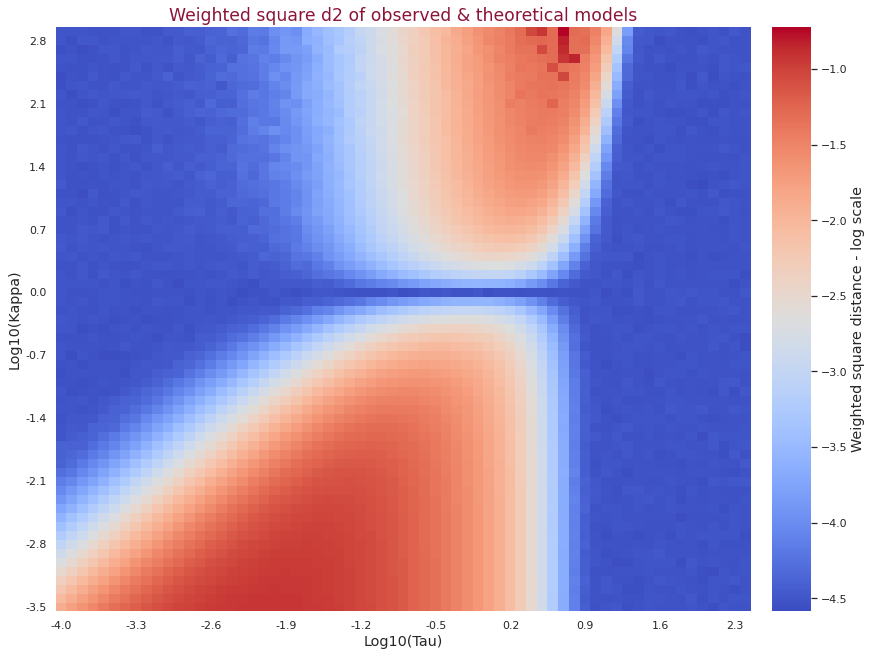

In [10]:
plot.plot_weighted_square_distance_heatmap(data=data_all, d2='d2 observed theoritical', models=['observed', 'theoretical'])

> Weighted square distance - observed SFS and inferred models

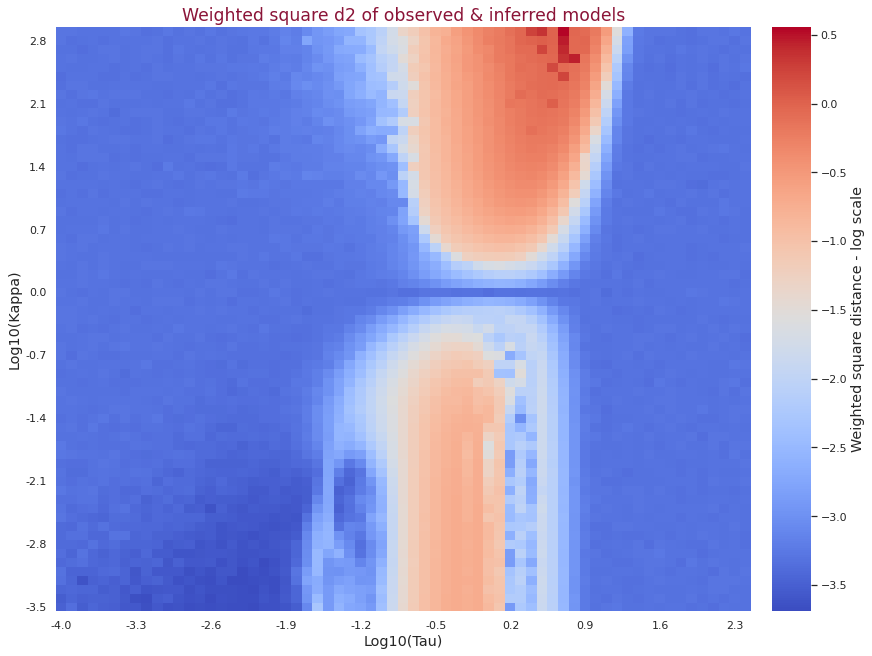

In [8]:
plot.plot_weighted_square_distance_heatmap(data=data_all, d2='d2 observed inferred', models=['observed', 'inferred'])

> Weighted square distance - M0 & M1

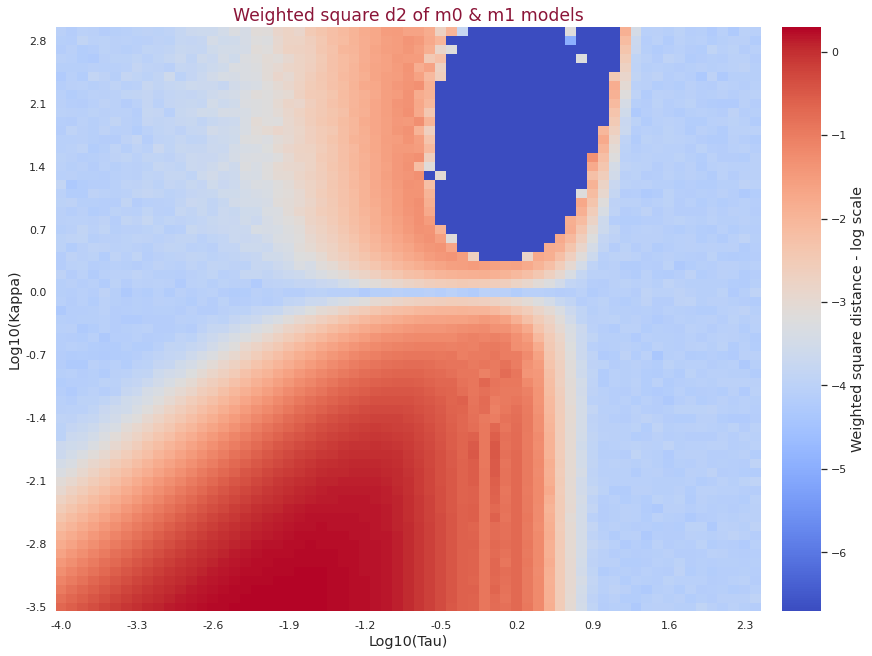

In [11]:
plot.plot_weighted_square_distance_heatmap(data=data_all, d2='d2 models', models=['m0', 'm1'])

<br>

> Log-likelihood ratio test

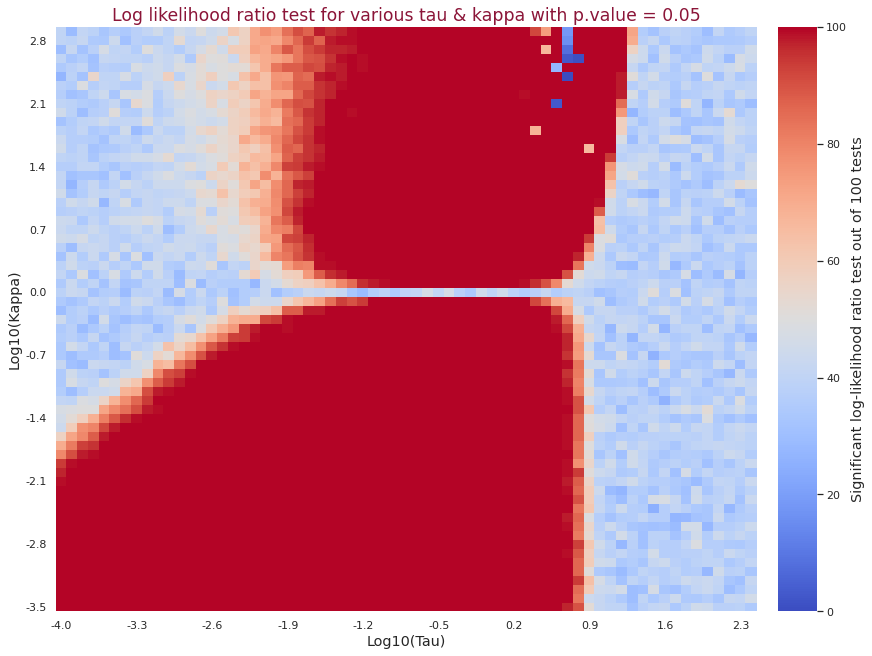

In [12]:
plot.plot_likelihood_heatmap(data_all)

> SFS shape

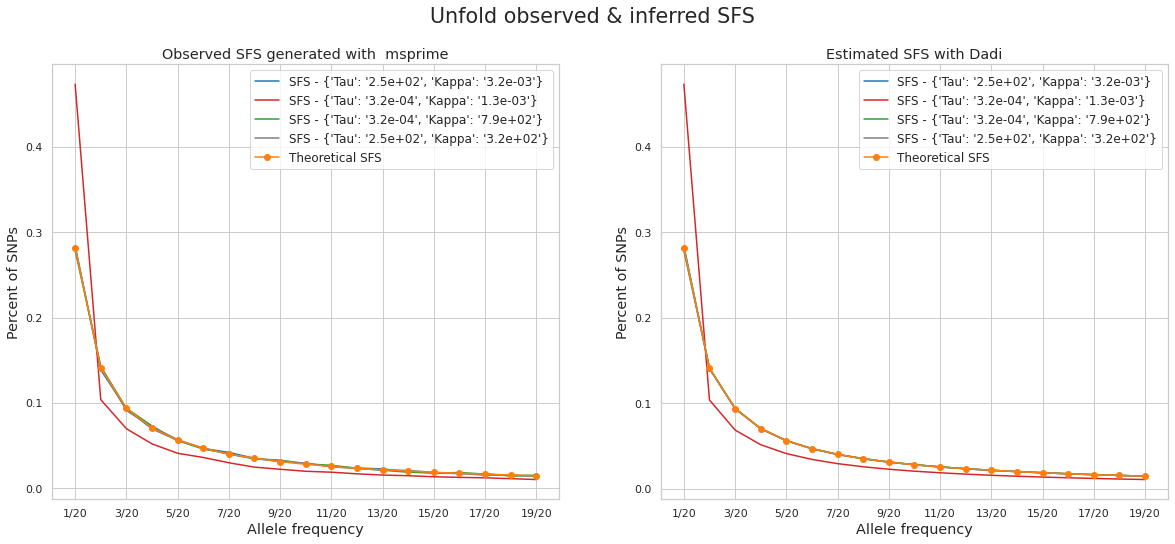

<Figure size 432x288 with 0 Axes>

In [14]:
plot.plot_sfs_inference(
    data=data_all, 
    parameters=[{'Tau': -3.5, 'Kappa': -2.9}, {'Tau': -3.5, 'Kappa': 2.9}, {'Tau': 2.4, 'Kappa': -2.5}, {'Tau': 2.4, 'Kappa': 2.5}], 
    colors=['tab:blue', 'tab:red', 'tab:green', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS"
)

<br>

> Vérification paramètre Dadi

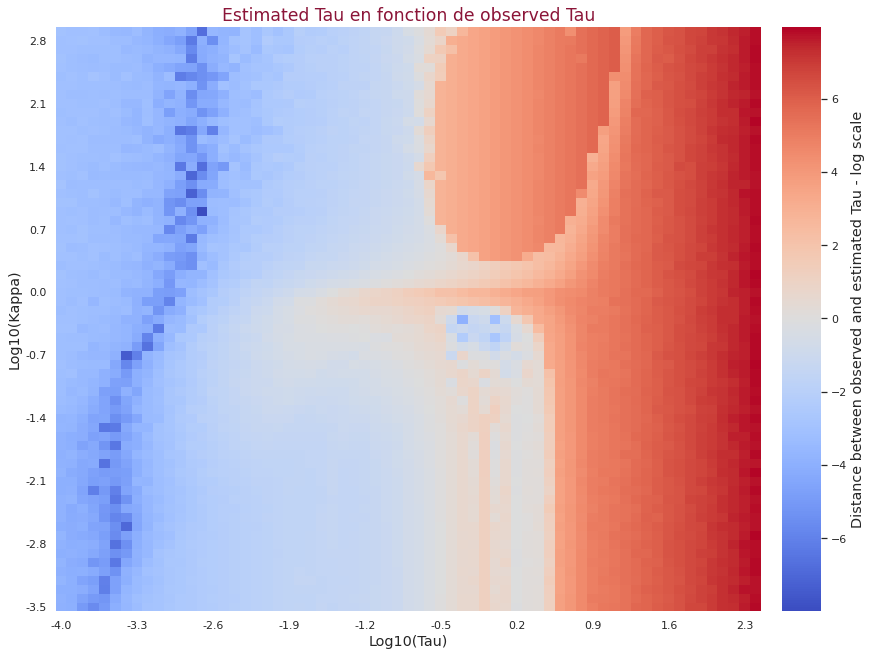

In [4]:
plot.plot_parameters_evaluation_heatmap(data_all, key="Tau")

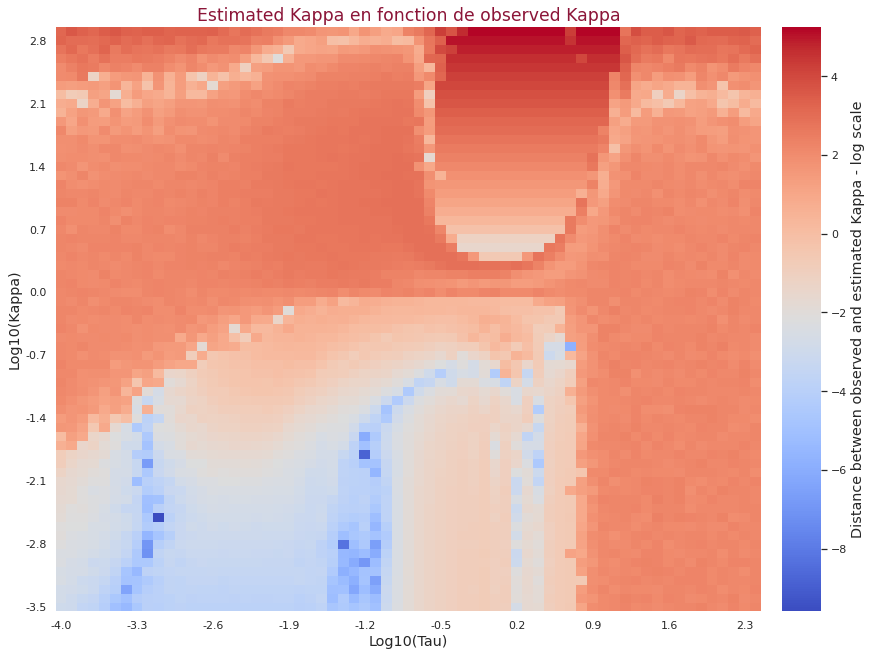

In [22]:
plot.plot_parameters_evaluation_heatmap(data_all, key="Kappa")

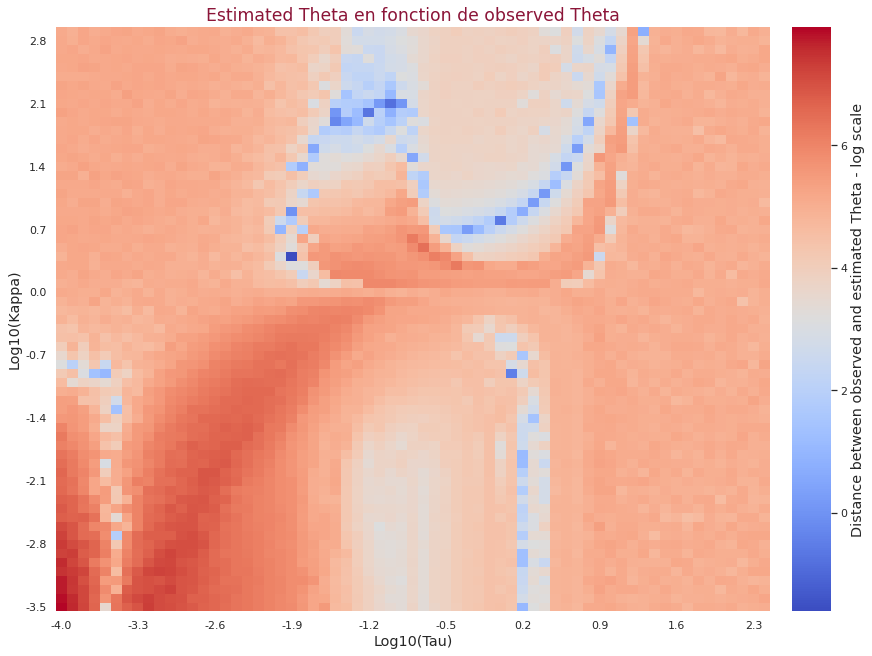

In [21]:
plot.plot_parameters_evaluation_heatmap(data_all, key="Theta")

<br>

# Fixed kappa - sudden decline & growth model 

## Kappa -3.5, 0. & 2.5 in log sacle, i.e. 3.2e-4, 1.0 & 3.2e2

In [5]:
s = "28638.62 14351.7 9557.06 7160.99 5719.14 4772.79 4092.08 3590.12 3186.29 2862.9 2598.45 2382.87 2197.96 2041.71 1906.56 1789.63 1673.89 1596.72 1507.08"
s = [float(ele) for ele in s.split(' ')]
s

[28638.62,
 14351.7,
 9557.06,
 7160.99,
 5719.14,
 4772.79,
 4092.08,
 3590.12,
 3186.29,
 2862.9,
 2598.45,
 2382.87,
 2197.96,
 2041.71,
 1906.56,
 1789.63,
 1673.89,
 1596.72,
 1507.08]

In [6]:
round(len(s)/2)

9.5

In [15]:
s[:round(len(s)/2)]

[28638.62,
 14351.7,
 9557.06,
 7160.99,
 5719.14,
 4772.79,
 4092.08,
 3590.12,
 3186.29,
 2862.9]

> Load data

In [2]:
data_kappa, labels_kappa = \
    f.export_specific_dadi_inference(model='decline', fold=False, fixed_param='kappa', values=[-2.5, 0., 2.5])

> Weighted square distance

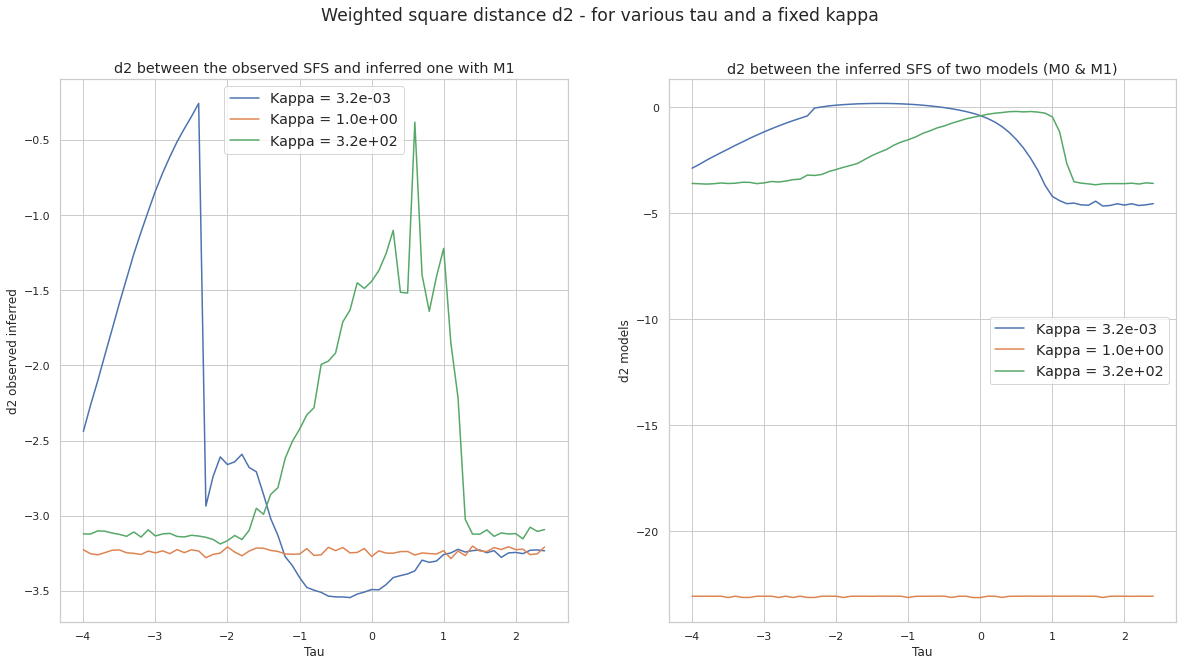

In [17]:
plot.plot_weighted_square_distance(
    data=data_kappa, fixed="Tau", labels=labels_kappa,
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa"
)

> Weighted square distance - observed SFS and theoritical SFS of any constant population

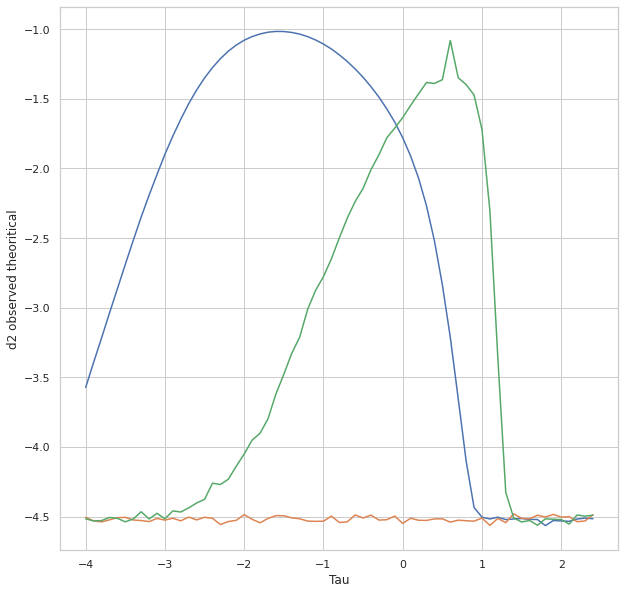

In [18]:
plt.figure(figsize=(10,10))
sns.set_theme(style='whitegrid')

for dataframe in data_kappa:
    # Data
    df = pd.DataFrame()
    df['Tau'] = dataframe['Parameters'].apply(lambda param: np.log10(param['Tau']))
    df['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(dataframe)).apply(np.log10)
    
    # Plot
    _ = sns.lineplot(x="Tau", y="d2 observed theoritical", data=df)

> SFS shape

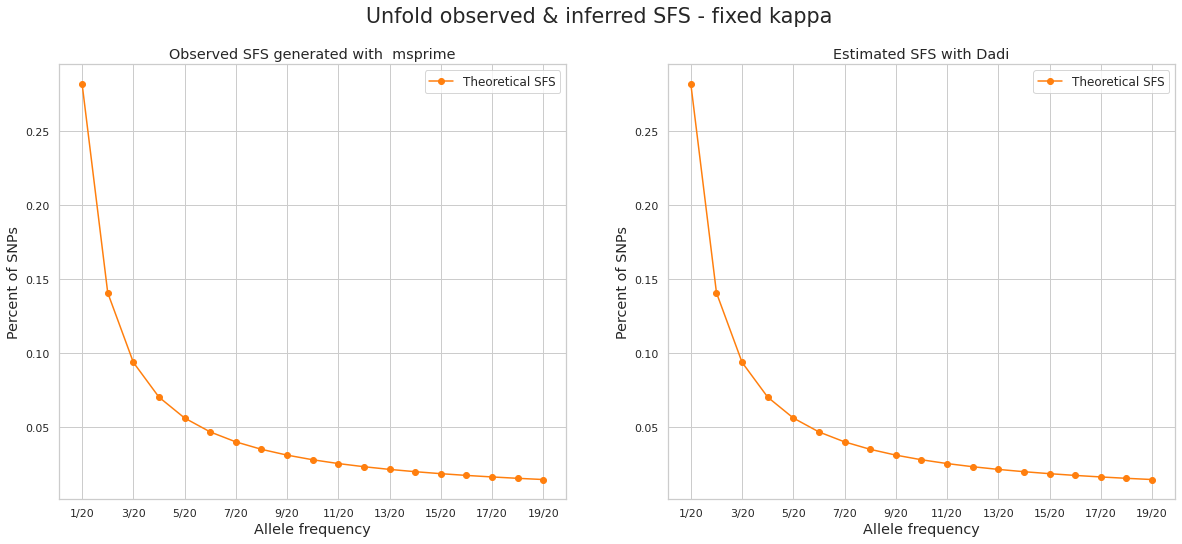

<Figure size 432x288 with 0 Axes>

In [19]:
plot.plot_sfs_inference(
    data=data_kappa[0], 
    parameters=[{'Tau': -3.5, 'Kappa': -3.5}, {'Tau': -3, 'Kappa': -3.5}, {'Tau': -2.5, 'Kappa': -3.5}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed kappa"
)

> Log-likelihood ratio test

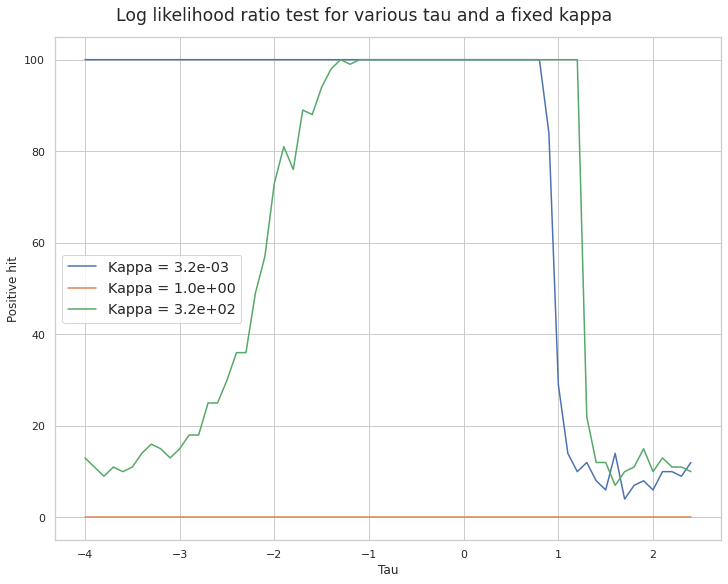

In [20]:
plot.plot_likelihood(
    data=data_kappa, fixed="Tau", labels=labels_kappa,
    suptitle="Log likelihood ratio test for various tau and a fixed kappa"
)

> Evaluation paramètres estimés

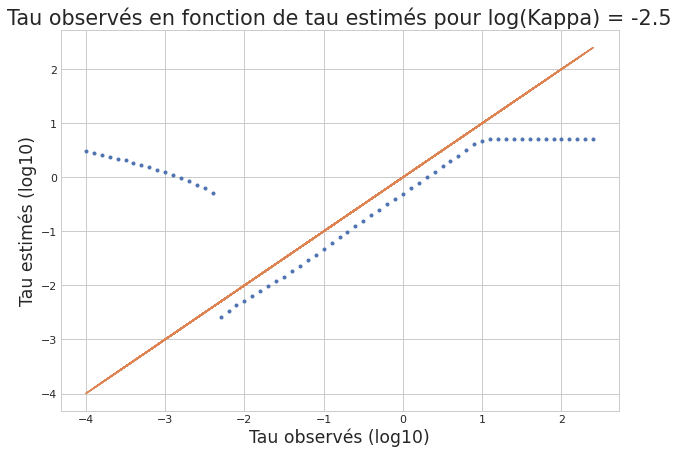

In [3]:
plot.plot_parameters_evaluation(data=data_kappa[0], key="Tau", fixed=('Kappa', -2.5))

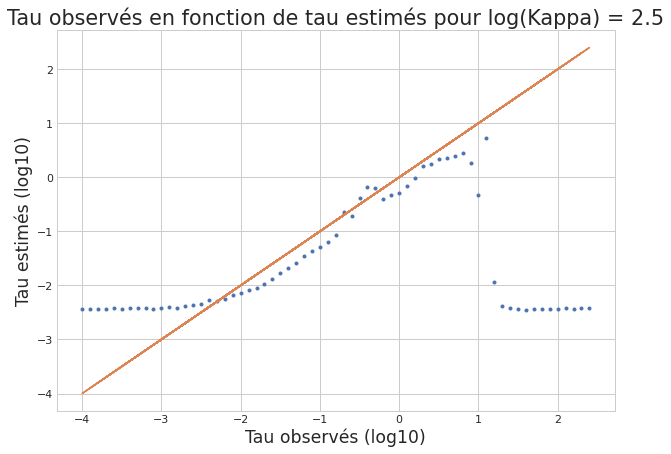

In [4]:
plot.plot_parameters_evaluation(data=data_kappa[2], key="Tau", fixed=('Kappa', 2.5))

<br>

## Kappa 0.3 & 1 in log scale, i.e. 2 & 10

> Load data

In [6]:
data_kappa2, labels_kappa2 = \
    f.export_specific_dadi_inference(model='decline', fold=False, fixed_param='kappa', values=[0.3, 1.])

> Weighted square distance

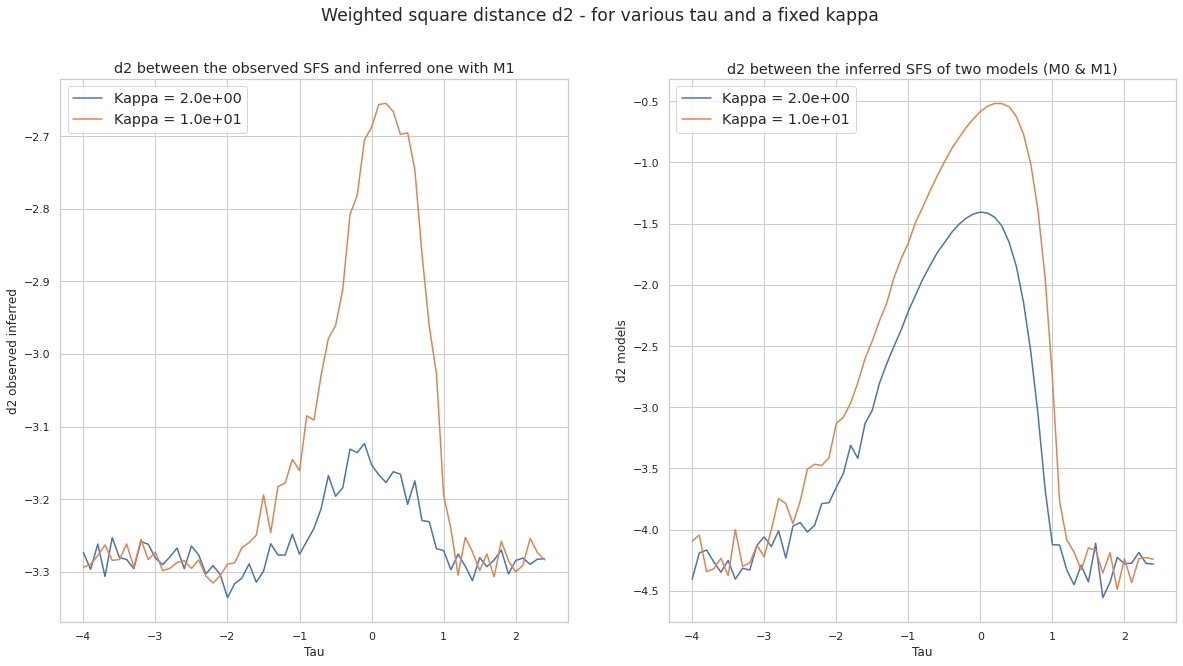

In [24]:
plot.plot_weighted_square_distance(
    data=data_kappa2, fixed="Tau", labels=labels_kappa2,
    suptitle="Weighted square distance d2 - for various tau and a fixed kappa"
)

> Log-likelihood ratio test

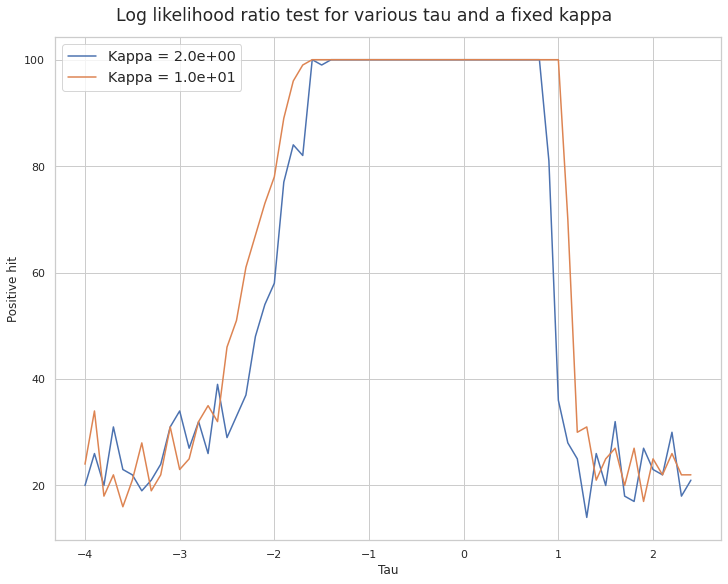

In [25]:
plot.plot_likelihood(
    data=data_kappa2, fixed="Tau", labels=labels_kappa2,
    suptitle="Log likelihood ratio test for various tau and a fixed kappa"
)

> SFS shape

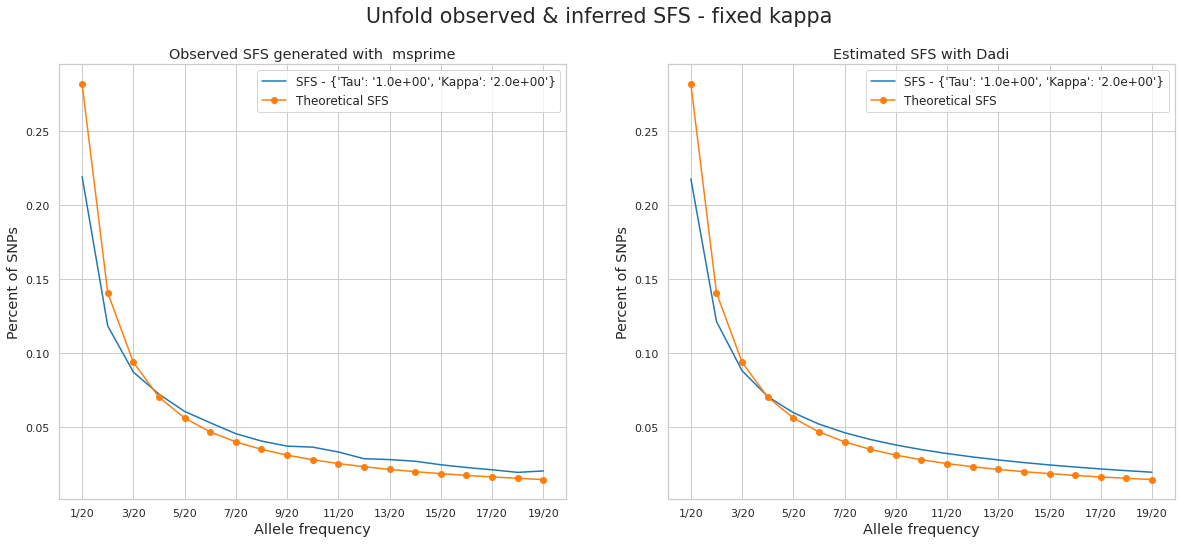

<Figure size 432x288 with 0 Axes>

In [26]:
plot.plot_sfs_inference(
    data=data_kappa2[0], 
    parameters=[{'Tau': 0., 'Kappa': 0.3}, {'Tau': 0., 'Kappa': 1}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed kappa"
)

> Evaluation paramètres estimés

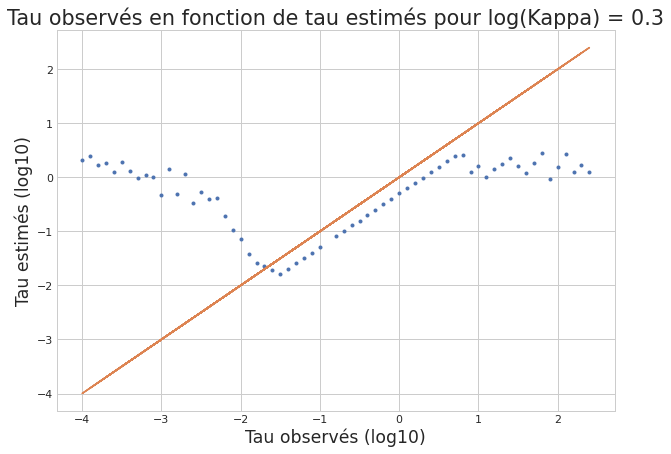

In [15]:
plot.plot_parameters_evaluation(data=data_kappa2[0], key="Tau", fixed=('Kappa', 0.3))

<br>

## Fixed tau - sudden decline & growth model 

### Tau -2.4, 0. & 2.4, i.e. 4e-3, 1. & 251

> Load data

In [5]:
data_tau, labels_tau = \
    f.export_specific_dadi_inference(model='decline', fold=False, fixed_param='tau', values=[-2.4, 0., 2.4])

> Weighted square distance

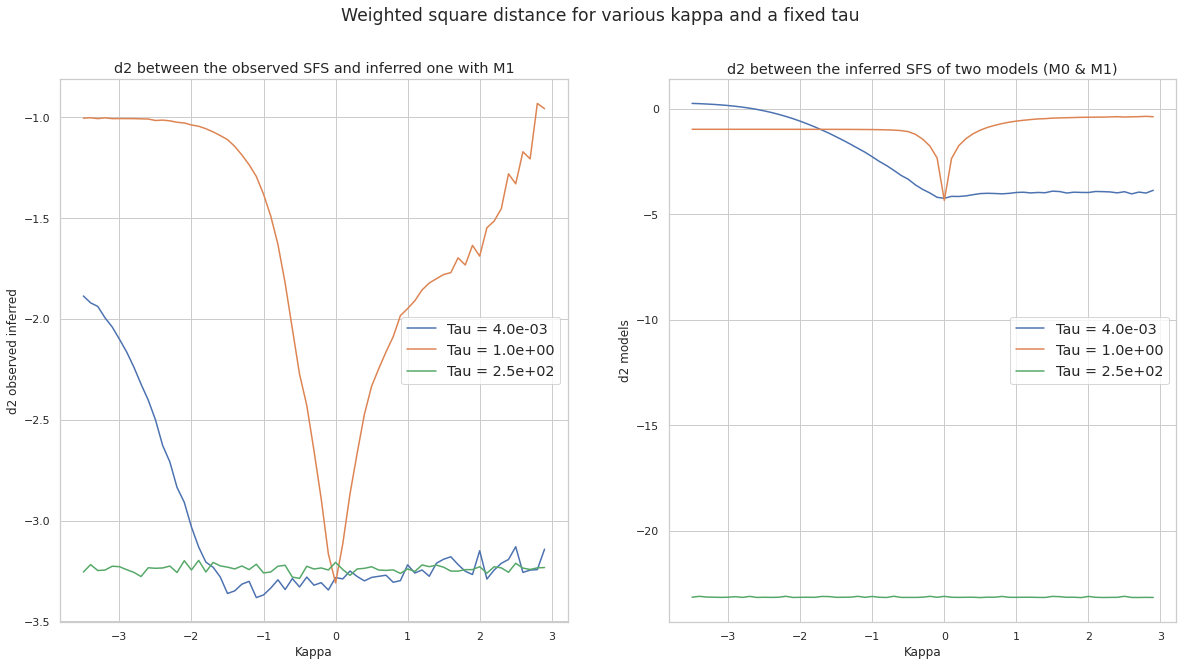

In [6]:
plot.plot_weighted_square_distance(
    data=data_tau, fixed="Kappa", labels=labels_tau,
    suptitle="Weighted square distance for various kappa and a fixed tau")

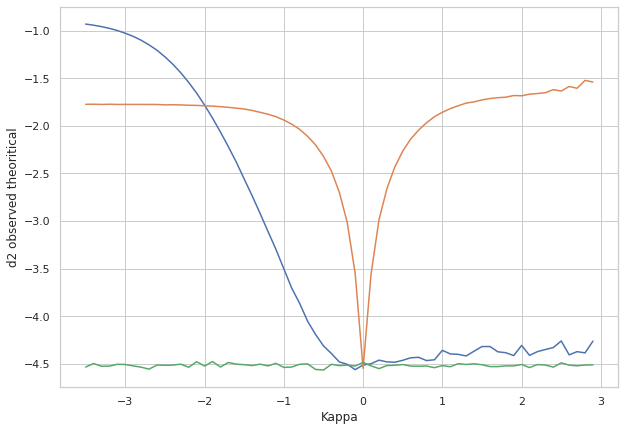

In [7]:
plt.figure(figsize=(10,7))
sns.set_theme(style='whitegrid')

for dataframe in data_tau:
    # Data
    df = pd.DataFrame()
    df['Kappa'] = dataframe['Parameters'].apply(lambda param: np.log10(param['Kappa']))
    df['d2 observed theoritical'] = pd.Series(compute_weighted_square_distance(dataframe)).apply(np.log10)
    
    # Plot
    _ = sns.lineplot(x="Kappa", y="d2 observed theoritical", data=df)

> Log-likelihood ratio test

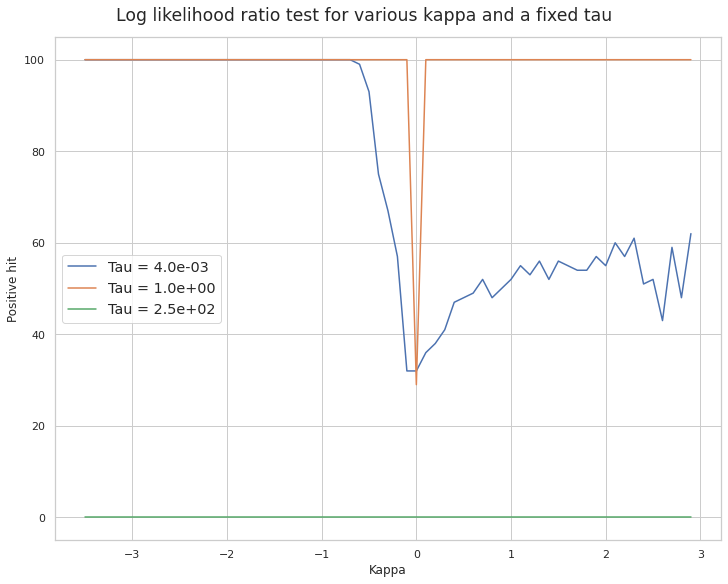

In [8]:
plot.plot_likelihood(
    data=data_tau, fixed="Kappa", labels=labels_tau,
    suptitle="Log likelihood ratio test for various kappa and a fixed tau")

> SFS shape

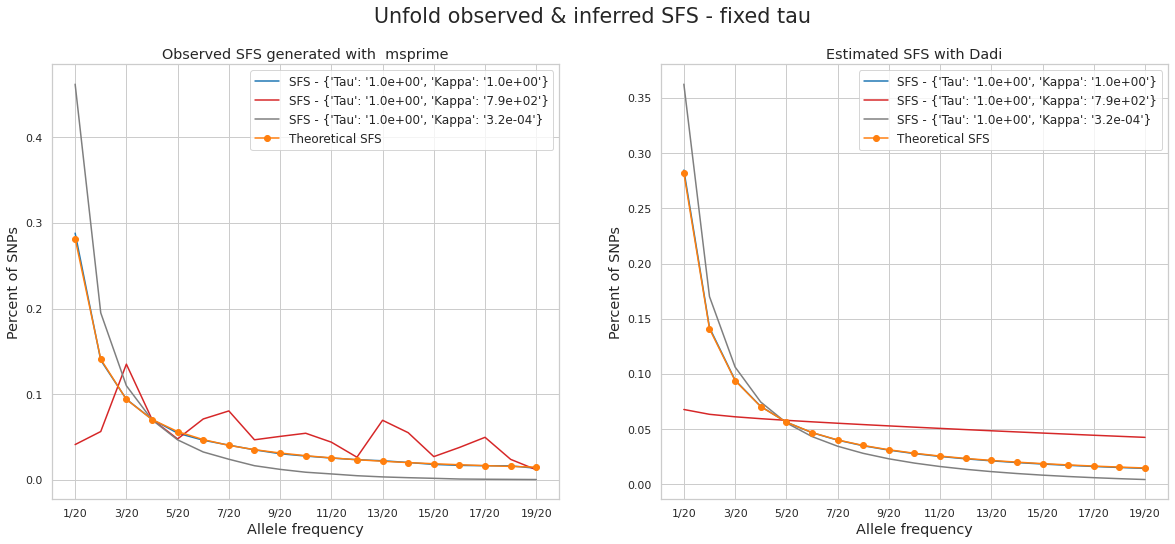

<Figure size 432x288 with 0 Axes>

In [32]:
plot.plot_sfs_inference(
    data=data_tau[1], 
    parameters=[{'Tau': 0., 'Kappa': -3.5}, {'Tau': 0., 'Kappa': 0}, {'Tau': 0., 'Kappa': 2.9}], 
    colors=['tab:blue', 'tab:red', 'tab:gray'],
    suptitle="Unfold observed & inferred SFS - fixed tau"
)

> Evaluation paramètres estimés

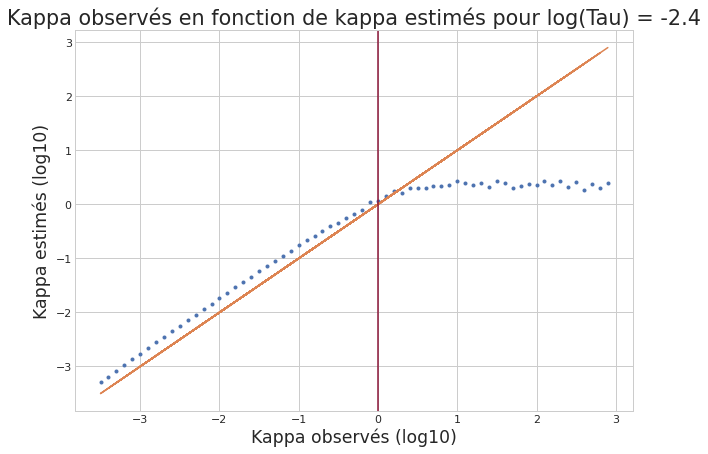

In [11]:
plot.plot_parameters_evaluation(data=data_tau[0], key="Kappa", fixed=('Tau', -2.4))